In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import math
from skimage.filters import gaussian
from sklearn.metrics import mean_squared_error
from ipywidgets import *

In [2]:
def point_moved(ang, cx, cy, r):
    ang_r = math.radians(ang)
    x = cx + math.sin(ang_r)*r
    y = cy + math.cos(ang_r)*r
    return [x, y, ang]

def initial_position(emiters, detectors, n, c_center, r, distance):
    if n%2 != 0:
        emiters[n//2] = point_moved(0, c_center[0], c_center[1], r)
        detectors[n//2] = point_moved(180, c_center[0], c_center[1], r)
        for i in range(n//2):
            emiters[i] = point_moved(360-(n//2-i)*distance, c_center[0], c_center[1], r)
            detectors[i] = point_moved(180+(n//2-i)*distance, c_center[0], c_center[1], r)
        for i in range(n//2+1, n):
            emiters[i] = point_moved((i-n//2)*distance, c_center[0], c_center[1], r)
            detectors[i] = point_moved(180-(i-n//2)*distance, c_center[0], c_center[1], r)
    else:
        for i in range(n//2):
            emiters[i] = point_moved(360-(distance/2)-(n//2-i-1)*distance, c_center[0], c_center[1], r)
            detectors[i] = point_moved(180+(distance/2)+(n//2-i-1)*distance, c_center[0], c_center[1], r)
        for i in range(n//2, n):
            emiters[i] = point_moved((distance/2)+(i-n//2)*distance, c_center[0], c_center[1], r)
            detectors[i] = point_moved(180-(distance/2)-(i-n//2)*distance, c_center[0], c_center[1], r)
            
def BresenhamLineGetSum(x1, y1, x2, y2):
    x1 = math.floor(x1)
    y1 = math.floor(y1)
    x2 = math.floor(x2)
    y2 = math.floor(y2)
    # zmienne pomocnicze
    suma = 0
    count = 0
    ai = bi = xi = yi = 0
    d = dx = dy = 0
    x = x1
    y = y1 
    
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
     
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
     
    # pierwszy piksel
    suma += image[x][y]
    count+=1
    # wstawianie piksela na obraz -> glVertex2i(x, y);
     # oś wiodąca OX
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
         # pętla po kolejnych x
        while x != x2:
             # test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            # wstawianie piksela na obraz -> glVertex2i(x, y);
            suma += image[x][y]
            count+=1
     # oś wiodąca OY
    else: 
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
         #pętla po kolejnych y
        while y != y2:
            #test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            #glVertex2i(x, y);
            #print(suma)
            suma += image[x][y]
            count+=1
    return [suma, count]
            
    
def BresenhamLineMakeOutput(x1, y1, x2, y2, value, output_image, mapa):
    x1 = math.floor(x1)
    y1 = math.floor(y1)
    x2 = math.floor(x2)
    y2 = math.floor(y2)
    # zmienne pomocnicze
    
    ai = bi = xi = yi = 0
    d = dx = dy = 0
    x = x1
    y = y1 
    
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
     
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
     
    # pierwszy piksel
    output_image[x][y]+=value
    mapa[x][y] += 1
    # wstawianie piksela na obraz -> glVertex2i(x, y);
     # oś wiodąca OX
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
         # pętla po kolejnych x
        while x != x2:
             # test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            # wstawianie piksela na obraz -> glVertex2i(x, y);
            output_image[x][y]+=value
            mapa[x][y] += 1
     # oś wiodąca OY
    else: 
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
         #pętla po kolejnych y
        while y != y2:
            #test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            #glVertex2i(x, y);
            #print(suma)
            output_image[x][y]+=value
            mapa[x][y]+=1

In [3]:
image = imread("examplebw.png")
c_center = [(image.shape[0]-1)/2, (image.shape[1]-1)/2] #środek okręgu wpisanego w zdjęcie wejściowe
r = (image.shape[0]-1)/2    #promień okręgu

In [4]:
#PARAMETRY DO USTAWIENIA:
angle = 1   #kąt obrotu
n = 601     #liczba emiterów
l = 150     #rozpiętość emiterów/detektorów

angle_radians = math.radians(angle)
no_of_rotations = 360//angle
distance = l/(n-1) #rozpiętość między emiterami/detektorami

emiters = np.zeros((n, 3))
detectors = np.zeros((n, 3))
initial_position(emiters, detectors, n, c_center, r, distance) 

In [5]:
#Wektor h będzie potrzebny do filtracji
k = 51
b = []
b.append(1)
for j in range(1, (k-1)//2):
    if j%2 == 0:
        b.append(0)
    else:
        s = (-4/np.pi**2)/(j**2)
        b.append(s)
h = []
h = np.concatenate((np.flip(b, 0), b[1:]), 0)    

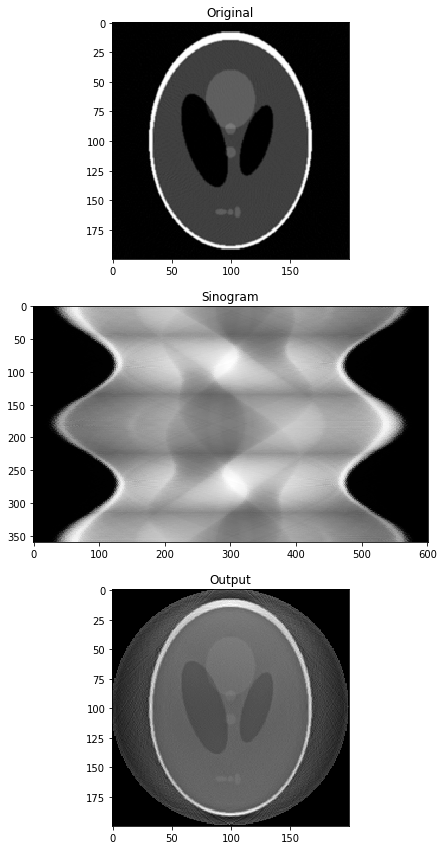

In [6]:
#Utworzenie sinogramu oraz mapy, przez ile pikseli przechodzi dany odcinek między emiterem a detektorem
sinogram_matrix = np.zeros((no_of_rotations, n))
sinogram_map = np.zeros((no_of_rotations, n))
for i in range(no_of_rotations):
    for j in range(n):
        sinogram_matrix[i][j], sinogram_map[i][j] = BresenhamLineGetSum(detectors[j][0], detectors[j][1], emiters[j][0], emiters[j][1])

        detectors[j] = point_moved((detectors[j][2]+angle)%360, c_center[0], c_center[1], r)
        emiters[j] = point_moved((emiters[j][2]+angle)%360, c_center[0], c_center[1], r)

#Splot sinogramu z utworzonym wcześniej wektorem
sinogram_filtered = []
for i in range(no_of_rotations):
    sinogram_filtered.append(np.convolve(h, sinogram_matrix[i], mode='same'))

#Odwrotna transformata Radona
output_image = np.zeros(image.shape)
mapa = np.array([[1 for i in range(image.shape[1])] for j in range(image.shape[0])])
initial_position(emiters, detectors, n, c_center, r, distance) 
for i in range(no_of_rotations):
    for j in range(n):
        value = sinogram_filtered[i][j]/sinogram_map[i][j]
        BresenhamLineMakeOutput(detectors[j][0], detectors[j][1], emiters[j][0], emiters[j][1], value, output_image, mapa)
        
        detectors[j] = point_moved((detectors[j][2]+angle)%360, c_center[0], c_center[1], r)
        emiters[j] = point_moved((emiters[j][2]+angle)%360, c_center[0], c_center[1], r)

#Filtracja
output_image = output_image/mapa
maximum = np.max(output_image)
minimum = np.min(output_image)
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        output_image[i][j] = ((output_image[i][j]-minimum)/(maximum-minimum))*255
bg = output_image[0][0]
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        output_image[i][j] = max(0, output_image[i][j]-bg)
        
#Wyświetlenie wyników
plt.figure(figsize=(20, 20))
plt.subplot(411)
plt.title("Original");
plt.imshow(image, cmap=plt.cm.Greys_r)

plt.subplot(412)
plt.title("Sinogram");
plt.imshow(sinogram_matrix, cmap=plt.cm.Greys_r)

plt.subplot(413)
plt.title("Output");
plt.imshow(output_image, cmap="gray")


In [ ]:
def draw(x = 0):
    emiters = [0]*n
    detectors = [0]*n
    initial_position(emiters, detectors, n, c_center,r, distance) 
    
    sinogram_matrix = [[0 for i in range(n)] for j in range(no_of_rotations)]
    sinogram_map = [[0 for i in range(n)] for j in range(no_of_rotations)]
    
    output_image = np.array([[0 for i in range(image.shape[1])] for j in range(image.shape[0])])
    mapa = np.array([[1 for i in range(image.shape[1])] for j in range(image.shape[0])])
    
    for i in range(x):
        for j in range(n):
            sinogram_matrix[i][j], sinogram_map[i][j] = BresenhamLineGetSum(detectors[j][0], detectors[j][1], emiters[j][0], emiters[j][1])
            value = sinogram_matrix[i][j]/sinogram_map[i][j]
            BresenhamLineMakeOutput(detectors[j][0], detectors[j][1], emiters[j][0], emiters[j][1], value, output_image, mapa)
        
            detectors[j] = point_moved((detectors[j][2]+angle)%360, c_center[0], c_center[1], r)
            emiters[j] = point_moved((emiters[j][2]+angle)%360, c_center[0], c_center[1], r)
    output_image = output_image/mapa
    maximum = np.max(output_image)
    minimum = np.min(output_image)
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            output_image[i][j] = ((output_image[i][j]-minimum)/(maximum-minimum))*255
    bg = output_image[0][0]
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            output_image[i][j] = max(0, output_image[i][j]-bg)
    
    plt.figure(figsize=(10, 15))
    plt.subplot(121)
    plt.title("Sinogram");
    plt.imshow(sinogram_matrix, cmap=plt.cm.Greys_r)

    plt.subplot(122)
    plt.title("Output");
    plt.imshow(output_image, cmap="gray")

    plt.show()

interact(draw, x=(0, no_of_rotations, 1))